In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [20]:
data = pd.read_csv( "C:\\Users\\Vittorio D'Onofrio\\Downloads\\insurance_cross_sell.csv", sep=",", index_col=0 )

# Preprocessing

In [21]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [22]:
data.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [23]:
data.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Nel dataset non ci sono valori mancanti.

In [24]:
data["Response"].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

Il problema di classificazione è sbilanciato a favore della classe 0.

C'è bisogno di un encoding per le variabili "Gender", "Vehicle_Age", "Vehicle Damage", "Policy sales channel" e "Region Code". Le feature "Gender", "Vehicle Age" e "Vehicle Damage" sono stringhe e quindi vanno trasformate in numeriche; le variabili "Policy Sales Channel" e "Region Code" sono categoriche.\
L'approccio è il seguente: \
    * per la variabile "Vehicle_Age" è sufficiente un ordinal encoding, \
    * decodifico tutte le altre con la one hot encoding, anche se ci sarà un numero molto grande di features,\
    * feature selection a partire dal dataset con molte features.

In [25]:
vehicle_age_mapping={
    "< 1 Year":1,
    "1-2 Year":2,
    "> 2 Years":3
}

data["Vehicle_Age"]=data["Vehicle_Age"].map(vehicle_age_mapping)

In [26]:
data= pd.get_dummies(data , columns=[ 'Policy_Sales_Channel' , 'Gender' , 'Vehicle_Damage', 'Region_Code'  ] )

In [27]:
data.head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Annual_Premium,Vintage,Response,Policy_Sales_Channel_1.0,Policy_Sales_Channel_2.0,Policy_Sales_Channel_3.0,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
id,,,,,,,,,,,,,,,,,,,,,
1,44,1,0,3,40454.0,217,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,76,1,0,2,33536.0,183,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47,1,0,3,38294.0,27,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21,1,1,1,28619.0,203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,29,1,1,1,27496.0,39,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
data.describe()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Annual_Premium,Vintage,Response,Policy_Sales_Channel_1.0,Policy_Sales_Channel_2.0,Policy_Sales_Channel_3.0,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.00000,381109.000000,...,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,0.458210,1.609616,30564.389581,154.347397,0.122563,0.002818,0.00001,0.001372,...,0.006925,0.002120,0.014707,0.051820,0.019511,0.012283,0.004807,0.026877,0.000480,0.000701
std,15.511611,0.046110,0.498251,0.567439,17213.155057,83.671304,0.327936,0.053011,0.00324,0.037019,...,0.082925,0.045996,0.120378,0.221663,0.138314,0.110144,0.069166,0.161724,0.021908,0.026459
min,20.000000,0.000000,0.000000,1.000000,2630.000000,10.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,0.000000,1.000000,24405.000000,82.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,1.000000,0.000000,2.000000,31669.000000,154.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,1.000000,1.000000,2.000000,39400.000000,227.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.000000,1.000000,1.000000,3.000000,540165.000000,299.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Proviamo a fare feature selection utilizzando la regressione logistica e la classe SelectFromModel di scikit-learn. In particolare, scegliendo 'threshold = mean' si scelgono le feature la cui importanza è superiore alla media delle importanze delle feature. Si possono provare anche altri parametri per la soglia, per il momento la media mi sembra un buon compromesso. 

In [30]:
Y= data["Response"]
X= data.drop("Response", axis=1)

X_train, X_test, Y_train, Y_test = train_test_split ( X,Y,test_size=.3 , random_state=10 )


ss = StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

lr_feature_sel=LogisticRegression()
lr_feature_sel.fit(X_train, Y_train)

sfm = SelectFromModel(lr_feature_sel, threshold='mean')
sfm.fit(X_train, Y_train)

selected_features_logistic = X.columns[sfm.get_support()]
print("Feature selezionate dalla regressione logistica:", selected_features_logistic)

Feature selezionate dalla regressione logistica: Index(['Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Policy_Sales_Channel_25.0', 'Policy_Sales_Channel_26.0',
       'Policy_Sales_Channel_46.0', 'Policy_Sales_Channel_63.0',
       'Policy_Sales_Channel_96.0', 'Policy_Sales_Channel_108.0',
       'Policy_Sales_Channel_118.0', 'Policy_Sales_Channel_122.0',
       'Policy_Sales_Channel_124.0', 'Policy_Sales_Channel_146.0',
       'Policy_Sales_Channel_151.0', 'Policy_Sales_Channel_152.0',
       'Policy_Sales_Channel_154.0', 'Policy_Sales_Channel_155.0',
       'Policy_Sales_Channel_156.0', 'Policy_Sales_Channel_157.0',
       'Policy_Sales_Channel_159.0', 'Policy_Sales_Channel_160.0',
       'Policy_Sales_Channel_163.0', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes',
       'Region_Code_0.0', 'Region_Code_8.0', 'Region_Code_11.0',
       'Region_Code_25.0', 'Region_Code_28.0', 'Region_Code_29.0',
       'Region_Code_41.0', 'Region_Code_44.0', 'Region_Code_48.0',
    

In [31]:
data = data[  ['Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Policy_Sales_Channel_25.0', 'Policy_Sales_Channel_26.0',
       'Policy_Sales_Channel_46.0', 'Policy_Sales_Channel_63.0',
       'Policy_Sales_Channel_96.0', 'Policy_Sales_Channel_108.0',
       'Policy_Sales_Channel_118.0', 'Policy_Sales_Channel_122.0',
       'Policy_Sales_Channel_124.0', 'Policy_Sales_Channel_146.0',
       'Policy_Sales_Channel_151.0', 'Policy_Sales_Channel_152.0',
       'Policy_Sales_Channel_154.0', 'Policy_Sales_Channel_155.0',
       'Policy_Sales_Channel_156.0', 'Policy_Sales_Channel_157.0',
       'Policy_Sales_Channel_159.0', 'Policy_Sales_Channel_160.0',
       'Policy_Sales_Channel_163.0', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes',
       'Region_Code_0.0', 'Region_Code_8.0', 'Region_Code_11.0',
       'Region_Code_25.0', 'Region_Code_28.0', 'Region_Code_29.0',
       'Region_Code_41.0', 'Region_Code_44.0', 'Region_Code_48.0',
       'Region_Code_50.0' ,  'Response' ] ]

#  Costruzione del modello

In [32]:
def classification_report(y_true, y_pred):
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"f1 score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

In [33]:
def evaluate_model(model, dataset, subset):
    X, y_true = dataset
    y_pred = model.predict(X)
    print(f"METRICHE SUL {subset}:\n ")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"f1 score: {f1_score(y_true, y_pred):.3f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f} \n")
    print(f"MATRICE DI CONFUSIONE: \n {confusion_matrix(y_true, y_pred)}") 

In [34]:
Y= data["Response"].values
X= data.drop("Response", axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split ( X,Y,test_size=.3 , random_state=10 )


ss = StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

lr=LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

In [35]:
evaluate_model(lr , (X_train,Y_train), "TRAIN")

METRICHE SUL TRAIN:
 
Precision: 0.359
Recall: 0.002
f1 score: 0.003
Accuracy: 0.877 

MATRICE DI CONFUSIONE: 
 [[233908     93]
 [ 32723     52]]


In [36]:
evaluate_model(lr , (X_test,Y_test), "TEST")

METRICHE SUL TEST:
 
Precision: 0.403
Recall: 0.002
f1 score: 0.004
Accuracy: 0.878 

MATRICE DI CONFUSIONE: 
 [[100355     43]
 [ 13906     29]]


Osservazione: in questo caso il dataset è sbilanciato a favore della classe negativa (0). Il modello di regressione logistica ottenuto senza pesare le classi produce una recall molto bassa, quindi c'è un numero di falsi negativi molto alto e perciò il modello classifica quasi sempre come negative le vere classi positive. Anche la precision è abbastanza bassa, ovvero ci sono molti falsi positivi, e questo indica che una gran parte degli esempi classificati come positivi in realtà era negativo. Nonostante questo, la accuracy del modello è molto alta, questo perchè probabilmente essendo il dataset sbilanciato, viene predetta quasi sempre la classe negativa e visto che le classi negative sono molte di più rispetto alle classi positive, ottengo una accuracy molto alta. 

A questo punto, ci interessa sviluppare un modello che abbia una recall molto alta. Questo perchè un modello con una recall alta riduce il numero di falsi negativi. Nel problema di business, questo significa che il modello con alta recall è in grado di individuare un gran numero di clienti che accetterebbero l'offerta. In pratica, è più importante non lasciarci scappare un cliente che avrebbe accettato l'offerta perchè il modello l'ha classificato come "non interessato" (alta recall) anche sacrificando un po' di precision, che nel caso del modello significa che tanti classificati come "interessati" all'offerta in realtà non lo sono.

Nel seguito quindi privilegiamo modelli che abbiano una recall alta mantenendo comunque un buon compromesso con la accuracy e la precision.

# class_weight

In [37]:
lr2 = LogisticRegression(class_weight="balanced")
lr2.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced')

In [38]:
evaluate_model(lr2, (X_train, Y_train) , "TRAIN")

METRICHE SUL TRAIN:
 
Precision: 0.270
Recall: 0.946
f1 score: 0.420
Accuracy: 0.679 

MATRICE DI CONFUSIONE: 
 [[150196  83805]
 [  1786  30989]]


In [39]:
evaluate_model(lr2, (X_test, Y_test) , "TEST")

METRICHE SUL TEST:
 
Precision: 0.267
Recall: 0.941
f1 score: 0.416
Accuracy: 0.678 

MATRICE DI CONFUSIONE: 
 [[64389 36009]
 [  822 13113]]


Bilanciando le due classi otteniamo una recall molto alta.

Si può inoltre provare a cercare manualmente con la cross-validation quali possono essere i parametri migliori con cui bilanciare il dataset. In particolare, visto che il problema è la recall, si possono cercare i parametri che rendono migliore questa misura.

In [40]:
model = LogisticRegression()

param_grid = {
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10},  {0: 1, 1: 20} ]
}


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')


grid_search.fit(X_train, Y_train)


print("Migliori parametri:", grid_search.best_params_)
print("Miglior punteggio di cross-validation:", grid_search.best_score_)


best_model = grid_search.best_estimator_

Migliori parametri: {'class_weight': {0: 1, 1: 20}}
Miglior punteggio di cross-validation: 0.986788710907704


Proviamo a vedere precisione e accuracy del modello individuato

In [41]:
evaluate_model(best_model, (X_train, Y_train) , "TRAIN")

METRICHE SUL TRAIN:
 
Precision: 0.244
Recall: 0.987
f1 score: 0.392
Accuracy: 0.623 

MATRICE DI CONFUSIONE: 
 [[133952 100049]
 [   433  32342]]


In [42]:
evaluate_model(best_model, (X_test, Y_test) , "TEST")

METRICHE SUL TEST:
 
Precision: 0.243
Recall: 0.985
f1 score: 0.389
Accuracy: 0.623 

MATRICE DI CONFUSIONE: 
 [[57508 42890]
 [  203 13732]]


Proviamo a vedere se si può migliorare ancora la recall, ad esempio fissando una soglia per la probabilità di assegnazione alla classe positiva, minore è la soglia e più alta sarà la recall. Cerchiamo quindi una soglia che sia inferiore a 0.5 (quella di default) senza però compromettere eccessivamente la precision.

Modifichiamo leggermente la funzione di valutazione:

In [43]:
def evaluate_model_proba(model, dataset, subset, threshold):
    X, y_true = dataset
    y_proba_pred = model.predict_proba(X)[:,1]
    
    binary_predictions = (y_proba_pred > threshold).astype(int)

    print(f"METRICHE SUL {subset}:\n ")
    print(f"Precision: {precision_score(y_true, binary_predictions):.3f}")
    print(f"Recall: {recall_score(y_true, binary_predictions):.3f}")
    print(f"f1 score: {f1_score(y_true, binary_predictions):.3f}")
    print(f"Accuracy: {accuracy_score(y_true, binary_predictions):.3f} \n")
    print(f"MATRICE DI CONFUSIONE: \n {confusion_matrix(y_true, binary_predictions)}") 

In [44]:
evaluate_model_proba(best_model, (X_train, Y_train), "TRAIN", 0.3)

METRICHE SUL TRAIN:
 
Precision: 0.234
Recall: 0.993
f1 score: 0.379
Accuracy: 0.600 

MATRICE DI CONFUSIONE: 
 [[127645 106356]
 [   237  32538]]


In [45]:
evaluate_model_proba(best_model, (X_test, Y_test), "TEST", 0.3)

METRICHE SUL TEST:
 
Precision: 0.233
Recall: 0.993
f1 score: 0.377
Accuracy: 0.600 

MATRICE DI CONFUSIONE: 
 [[54722 45676]
 [   98 13837]]


Con questa scelta del parametro di soglia la recall è migliorata senza peggiorare eccessivamente precision ed accuracy del modello ottenuto con la cross validation.

Proviamo a vedere se questo modello presenta overfitting, di nuovo usiamo la cross-validation

In [46]:
kf = KFold(n_splits=5, shuffle =True)

In [47]:
i=1
for train_index , test_index in kf.split(X):
    
    X_train , X_test = X[train_index] , X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    
    ss = StandardScaler()
    X_train=ss.fit_transform(X_train)
    X_test=ss.transform(X_test)

    print(f"Metriche dopo {i} split di cross-validation: \n")
    
    evaluate_model_proba(best_model, (X_train,Y_train) , "TRAIN", 0.3)
    evaluate_model_proba(best_model, (X_test,Y_test) , "TEST", 0.3)

    
    i+=1
    

Metriche dopo 1 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.234
Recall: 0.993
f1 score: 0.378
Accuracy: 0.600 

MATRICE DI CONFUSIONE: 
 [[145835 121682]
 [   277  37093]]
METRICHE SUL TEST:
 
Precision: 0.234
Recall: 0.994
f1 score: 0.379
Accuracy: 0.601 

MATRICE DI CONFUSIONE: 
 [[36552 30330]
 [   58  9282]]
Metriche dopo 2 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.234
Recall: 0.993
f1 score: 0.379
Accuracy: 0.600 

MATRICE DI CONFUSIONE: 
 [[145893 121549]
 [   261  37184]]
METRICHE SUL TEST:
 
Precision: 0.232
Recall: 0.992
f1 score: 0.376
Accuracy: 0.599 

MATRICE DI CONFUSIONE: 
 [[36495 30462]
 [   74  9191]]
Metriche dopo 3 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.234
Recall: 0.993
f1 score: 0.378
Accuracy: 0.600 

MATRICE DI CONFUSIONE: 
 [[145761 121767]
 [   253  37106]]
METRICHE SUL TEST:
 
Precision: 0.235
Recall: 0.991
f1 score: 0.379
Accuracy: 0.602 

MATRICE DI CONFUSIONE: 
 [[36631 30240]
 [   82  9269]

Si osserva che le metriche risultano quasi uguali per ogni split fatto dalla cross validation. Il modello non presenta dunque overfitting, ha una recall molto alta ed è quindi un ottimo candidato.

## Undersampling

In [48]:
from imblearn.under_sampling import RandomUnderSampler

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split ( X,Y,test_size=.3 , random_state=20 )

undersampler = RandomUnderSampler(sampling_strategy='auto' )

X_resampled, Y_resampled = undersampler.fit_resample(X_train, Y_train)

In [50]:
ss = StandardScaler()

X_resampled=ss.fit_transform(X_resampled)
X_test=ss.transform(X_test)

lr_under=LogisticRegression()
lr_under.fit(X_resampled, Y_resampled)

LogisticRegression()

In [51]:
evaluate_model(lr_under, (X_resampled, Y_resampled), "TRAIN")

METRICHE SUL TRAIN:
 
Precision: 0.725
Recall: 0.942
f1 score: 0.819
Accuracy: 0.792 

MATRICE DI CONFUSIONE: 
 [[21030 11694]
 [ 1893 30831]]


In [52]:
evaluate_model(lr_under, (X_test, Y_test), "TEST")

METRICHE SUL TEST:
 
Precision: 0.269
Recall: 0.945
f1 score: 0.419
Accuracy: 0.680 

MATRICE DI CONFUSIONE: 
 [[64508 35839]
 [  775 13211]]


Possiamo anche scegliere manualmente la porzione di osservazioni da cancellare della classe maggioritaria

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split ( X,Y,test_size=.3 , random_state=20 )

undersampler = RandomUnderSampler(sampling_strategy=0.8 )

X_resampled, Y_resampled = undersampler.fit_resample(X_train, Y_train)

In [54]:
ss = StandardScaler()

X_resampled=ss.fit_transform(X_resampled)
X_test=ss.transform(X_test)

lr4=LogisticRegression()
lr4.fit(X_resampled, Y_resampled)

LogisticRegression()

In [55]:
evaluate_model(lr4, (X_resampled, Y_resampled), "TRAIN")

METRICHE SUL TRAIN:
 
Precision: 0.700
Recall: 0.889
f1 score: 0.784
Accuracy: 0.782 

MATRICE DI CONFUSIONE: 
 [[28461 12444]
 [ 3624 29100]]


In [56]:
evaluate_model(lr4, (X_test, Y_test), "TEST")

METRICHE SUL TEST:
 
Precision: 0.290
Recall: 0.892
f1 score: 0.437
Accuracy: 0.719 

MATRICE DI CONFUSIONE: 
 [[69792 30555]
 [ 1517 12469]]


Questi risultati sono peggiori rispetto alla "sampling_strategy='auto'" e in realtà abbassando ancora la soglia si ottengono risultati ancora peggiori. Perciò torniamo al modello "lr_under".

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split ( X,Y,test_size=.3 , random_state=20 )

undersampler = RandomUnderSampler(sampling_strategy='auto' )

X_resampled, Y_resampled = undersampler.fit_resample(X_train, Y_train)

In [58]:
ss = StandardScaler()

X_resampled=ss.fit_transform(X_resampled)
X_test=ss.transform(X_test)

lr_under=LogisticRegression()
lr_under.fit(X_resampled, Y_resampled)

LogisticRegression()

In [59]:
evaluate_model_proba (lr_under, (X_resampled, Y_resampled), "TRAIN", 0.3 )

METRICHE SUL TRAIN:
 
Precision: 0.702
Recall: 0.981
f1 score: 0.818
Accuracy: 0.782 

MATRICE DI CONFUSIONE: 
 [[19095 13629]
 [  631 32093]]


In [60]:
evaluate_model_proba (lr_under, (X_test, Y_test), "TEST", 0.3 )

METRICHE SUL TEST:
 
Precision: 0.248
Recall: 0.981
f1 score: 0.396
Accuracy: 0.634 

MATRICE DI CONFUSIONE: 
 [[58756 41591]
 [  260 13726]]


Questo modello presenta una recall molto buona sia sul train sia sul test set.

Proviamo a vedere se questo modello presenta overfitting.

In [61]:
undersampler = RandomUnderSampler(sampling_strategy='auto' )
i=1

for train_index , test_index in kf.split(X):
    X_train , X_test = X[train_index] , X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    

    X_resampled, Y_resampled = undersampler.fit_resample(X_train, Y_train)
    
    ss = StandardScaler()
    X_resampled=ss.fit_transform(X_resampled)
    X_test=ss.transform(X_test)

    lr_under.fit(X_resampled, Y_resampled)

    print(f"Metriche dopo {i} split di cross-validation: \n")
    
    evaluate_model_proba(lr_under, (X_resampled,Y_resampled) , "TRAIN", 0.3)
    evaluate_model_proba(lr_under, (X_test,Y_test) , "TEST", 0.3)

    
    i+=1

Metriche dopo 1 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.701
Recall: 0.982
f1 score: 0.818
Accuracy: 0.782 

MATRICE DI CONFUSIONE: 
 [[21699 15624]
 [  667 36656]]
METRICHE SUL TEST:
 
Precision: 0.249
Recall: 0.980
f1 score: 0.397
Accuracy: 0.634 

MATRICE DI CONFUSIONE: 
 [[39118 27717]
 [  184  9203]]
Metriche dopo 2 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.704
Recall: 0.982
f1 score: 0.820
Accuracy: 0.785 

MATRICE DI CONFUSIONE: 
 [[21962 15378]
 [  680 36660]]
METRICHE SUL TEST:
 
Precision: 0.249
Recall: 0.981
f1 score: 0.398
Accuracy: 0.635 

MATRICE DI CONFUSIONE: 
 [[39211 27641]
 [  181  9189]]
Metriche dopo 3 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.703
Recall: 0.983
f1 score: 0.820
Accuracy: 0.784 

MATRICE DI CONFUSIONE: 
 [[21916 15533]
 [  653 36796]]
METRICHE SUL TEST:
 
Precision: 0.245
Recall: 0.982
f1 score: 0.392
Accuracy: 0.630 

MATRICE DI CONFUSIONE: 
 [[38901 28060]
 [  163  9098]]
Metriche d

Neanche in questo caso il modello presenta overfitting e i risultati sono molto simili a quelli ottenuti con il modello della sezione class_weight.

# Oversampling

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split ( X,Y,test_size=.3 , random_state=42 )


smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)


ss = StandardScaler()
X_train_resampled=ss.fit_transform(X_train_resampled)
X_test=ss.transform(X_test)


lr_over = LogisticRegression()
lr_over.fit(X_train_resampled, Y_train_resampled)

LogisticRegression()

In [63]:
evaluate_model(lr_over, (X_train_resampled, Y_train_resampled) , "TRAIN")

METRICHE SUL TRAIN:
 
Precision: 0.730
Recall: 0.950
f1 score: 0.825
Accuracy: 0.799 

MATRICE DI CONFUSIONE: 
 [[151693  82511]
 [ 11621 222583]]


In [64]:
evaluate_model(lr_over, (X_test, Y_test), "TEST")

METRICHE SUL TEST:
 
Precision: 0.273
Recall: 0.933
f1 score: 0.423
Accuracy: 0.685 

MATRICE DI CONFUSIONE: 
 [[65085 35110]
 [  947 13191]]


In [65]:
evaluate_model_proba(lr_over, (X_train_resampled,Y_train_resampled), "TRAIN", 0.3 )

METRICHE SUL TRAIN:
 
Precision: 0.708
Recall: 0.983
f1 score: 0.823
Accuracy: 0.789 

MATRICE DI CONFUSIONE: 
 [[139216  94988]
 [  3911 230293]]


In [66]:
evaluate_model_proba(lr_over, (X_test, Y_test), "TEST", 0.3)

METRICHE SUL TEST:
 
Precision: 0.254
Recall: 0.973
f1 score: 0.403
Accuracy: 0.644 

MATRICE DI CONFUSIONE: 
 [[59828 40367]
 [  387 13751]]


Come nei modelli costruiti precedentemente, proviamo a vedere se questo modello presenta overfitting.

In [70]:
i=1
for train_index , test_index in kf.split(X):
    X_train , X_test = X[train_index] , X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    

    smote = SMOTE(random_state=42)
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)


    ss = StandardScaler()
    X_train_resampled=ss.fit_transform(X_train_resampled)
    X_test=ss.transform(X_test)


    lr_over = LogisticRegression()
    lr_over.fit(X_train_resampled, Y_train_resampled)


    print(f"Metriche dopo {i} split di cross-validation: \n")
    
    evaluate_model_proba(lr_over, (X_train_resampled,Y_train_resampled) , "TRAIN", 0.3)
    evaluate_model_proba(lr_over, (X_test,Y_test) , "TEST", 0.3)

    
    i+=1

Metriche dopo 1 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.707
Recall: 0.983
f1 score: 0.822
Accuracy: 0.788 

MATRICE DI CONFUSIONE: 
 [[158426 108992]
 [  4515 262903]]
METRICHE SUL TEST:
 
Precision: 0.248
Recall: 0.975
f1 score: 0.396
Accuracy: 0.639 

MATRICE DI CONFUSIONE: 
 [[39723 27258]
 [  231  9010]]
Metriche dopo 2 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.707
Recall: 0.984
f1 score: 0.823
Accuracy: 0.789 

MATRICE DI CONFUSIONE: 
 [[158752 108849]
 [  4334 263267]]
METRICHE SUL TEST:
 
Precision: 0.252
Recall: 0.976
f1 score: 0.400
Accuracy: 0.638 

MATRICE DI CONFUSIONE: 
 [[39454 27344]
 [  224  9200]]
Metriche dopo 3 split di cross-validation: 

METRICHE SUL TRAIN:
 
Precision: 0.708
Recall: 0.982
f1 score: 0.823
Accuracy: 0.789 

MATRICE DI CONFUSIONE: 
 [[159356 108138]
 [  4746 262748]]
METRICHE SUL TEST:
 
Precision: 0.252
Recall: 0.972
f1 score: 0.400
Accuracy: 0.644 

MATRICE DI CONFUSIONE: 
 [[40006 26899]
 [  257  9060]

Neanche questo modello presenta overfitting e dunque è anch'esso un ottimo candidato.

# ROC e AUC

Possiamo provare a visualizzare la curva roc e l'area sottesa a questa curva per i due modelli "lr_under" e "best_model" e "lr_over".

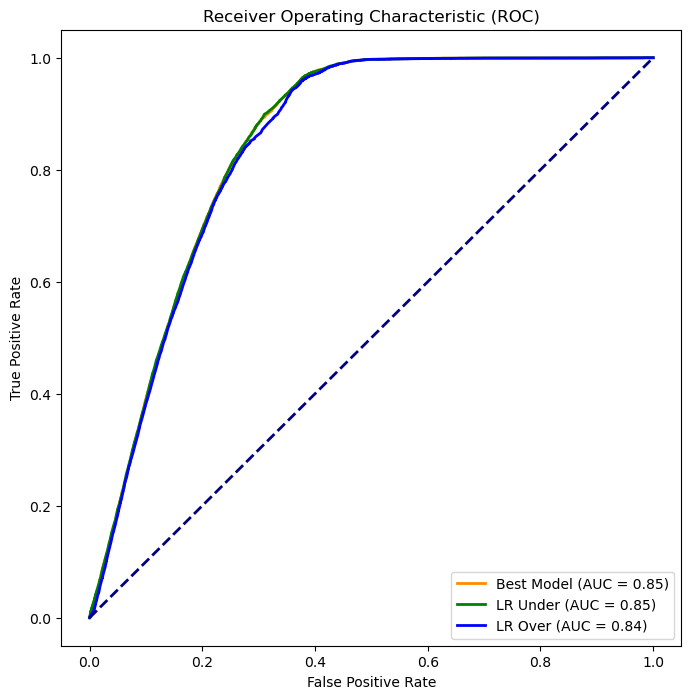

In [71]:
y_proba_best_model = best_model.predict_proba(X_test)[:, 1]
y_proba_lr_under = lr_under.predict_proba(X_test)[:, 1]
y_proba_lr_over = lr_over.predict_proba(X_test)[:,1]

fpr_best_model, tpr_best_model, _ = roc_curve(Y_test, y_proba_best_model)
roc_auc_best_model = auc(fpr_best_model, tpr_best_model)

fpr_lr_under, tpr_lr_under, _ = roc_curve(Y_test, y_proba_lr_under)
roc_auc_lr_under = auc(fpr_lr_under, tpr_lr_under)

fpr_lr_over, tpr_lr_over, _ = roc_curve(Y_test, y_proba_lr_over)
roc_auc_lr_over = auc(fpr_lr_over, tpr_lr_over)

plt.figure(figsize=(8, 8))

plt.plot(fpr_best_model, tpr_best_model, color='darkorange', lw=2, label='Best Model (AUC = {:.2f})'.format(roc_auc_best_model))
plt.plot(fpr_lr_under, tpr_lr_under, color='green', lw=2, label='LR Under (AUC = {:.2f})'.format(roc_auc_lr_under))
plt.plot(fpr_lr_over, tpr_lr_over, color='blue', lw=2, label='LR Over (AUC = {:.2f})'.format(roc_auc_lr_over))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


I tre modelli hanno una ROC e AUC quasi identica, dal grafico si può osservare che tutti e tre i modelli riescono a distinguere molto bene tra le due classi. 